 Dataset loaded


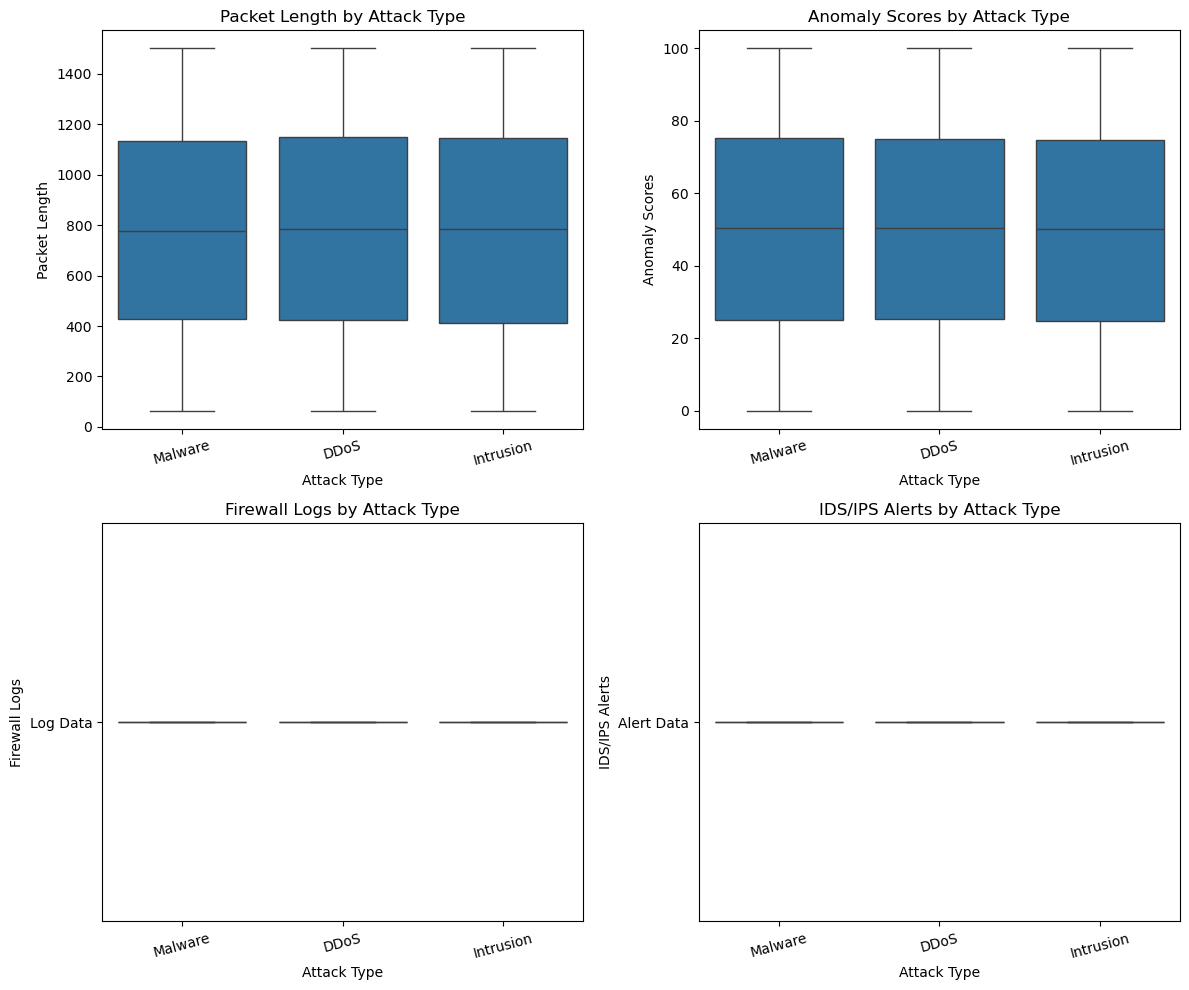

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Load the original dataset
csv_name = "cybersecurity_attacks.csv"
if os.path.exists(csv_name):
    df = pd.read_csv(csv_name)
    print(" Dataset loaded")
else:
    raise FileNotFoundError(f"'{csv_name}' not found in the current working directory.")

# Features to compare across attack types
features = ['Packet Length', 'Anomaly Scores', 'Firewall Logs', 'IDS/IPS Alerts']
attack_col = 'Attack Type'

# Plot distribution overlap
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x=attack_col, y=feature, data=df)
    plt.title(f"{feature} by {attack_col}")
    plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
import random
import uuid
from datetime import datetime, timedelta

# reproducibility
np.random.seed(21704)
random.seed(21704)

def gen_data(n=40000, noise_pct=0.05):
    recs = []
    types = ["DDoS", "Intrusion", "Malware"]
    pkt_types = ["Control", "Data"]
    trf_types = ["HTTP", "DNS", "FTP", "SSH"]

    for i in range(n):
        t = types[i % 3]
        ts = datetime(2023, 1, 1) + timedelta(seconds=random.randint(0, 86400 * 30))

        if t == "DDoS":
            dur = np.random.uniform(1, 80)
            pkts = int(np.random.uniform(1000, 3000))
            syn = np.random.uniform(0.1, 0.5)
            plen = np.random.normal(200, 80)
            ano = np.random.uniform(65, 90)
            proto = random.choice(["UDP", "ICMP", "TCP"])
            trf = random.choice(trf_types)
            sev = "High"
            act = random.choice(["Blocked", "Logged"])
        elif t == "Intrusion":
            dur = np.random.uniform(100, 250)
            pkts = int(np.random.uniform(500, 2200))
            syn = np.random.uniform(0.3, 0.7)
            plen = np.random.normal(350, 120)
            ano = np.random.uniform(45, 75)
            proto = "TCP"
            trf = random.choice(trf_types)
            sev = random.choice(["Medium", "High"])
            act = random.choice(["Logged", "Blocked"])
        else:  # Malware
            dur = np.random.uniform(300, 1800)
            pkts = int(np.random.uniform(150, 1800))
            syn = np.random.uniform(0.0, 0.4)
            plen = np.random.normal(600, 200)
            ano = np.random.uniform(20, 60)
            proto = "TCP"
            trf = random.choice(["HTTP", "FTP", "DNS"])
            sev = random.choice(["Low", "Medium"])
            act = random.choice(["Logged", "Ignored"])

        pps = pkts / max(dur, 1)
        recs.append({
            "id": str(uuid.uuid4()),
            "ts": ts,
            "dur": round(dur, 2),
            "pkts": pkts,
            "pps": round(pps, 2),
            "syn": round(syn, 3),
            "plen": round(max(plen, 1), 2),
            "ano": round(ano, 2),
            "proto": proto,
            "pkt_type": random.choice(pkt_types),
            "trf_type": trf,
            "sev": sev,
            "act": act,
            "label": t
        })

    df = pd.DataFrame(recs)

    # noise: 20% missing in numeric cols
    for c in ["plen", "ano", "pps", "syn"]:
        df.loc[np.random.rand(len(df)) < 0.20, c] = np.nan

    # 10% duplicates
    df = pd.concat([df, df.sample(frac=0.10, random_state=21704)], ignore_index=True)

    # 5% outliers
    for c in ["plen", "ano", "pps", "pkts"]:
        idx = df.sample(frac=0.05, random_state=21704).index
        df.loc[idx, c] = df[c].max() * 10

    # 5% label flips
    mask = np.random.rand(len(df)) < noise_pct
    df.loc[mask, "label"] = df.loc[mask, "label"].apply(
        lambda x: random.choice([o for o in types if o != x])
    )

    # shuffle & save
    df = df.sample(frac=1, random_state=21704).reset_index(drop=True)
    df.to_csv("synthetic_cyber_attacks.csv", index=False)
    print("Saved synthetic_cyber_attacks.csv")

    return df

# Generate dataset
df = gen_data()


Saved synthetic_cyber_attacks.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from sklearn.ensemble       import RandomForestClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.svm            import SVC
from sklearn.metrics        import classification_report, confusion_matrix

# Load
csv_file = "synthetic_cyber_attacks.csv"
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file, parse_dates=["ts"])
    print("synthetic_cyber_attacks.csv loaded successfully.")
    print("Raw shape:", df.shape)
    display(df.head())
else:
    raise FileNotFoundError(f"'{csv_file}' not found. Please ensure it is in the same directory as the notebook.")

synthetic_cyber_attacks.csv loaded successfully.
Raw shape: (44000, 14)


,id,ts,dur,pkts,pps,syn,plen,ano,proto,pkt_type,trf_type,sev,act,label
0,5376c6a2-b5a0-4232-b8cd-2dc8c2dc6a19,2023-01-16 04:12:05,1343.92,29990,28419.9,0.014,13299.2,900.0,TCP,Control,HTTP,Medium,Ignored,Malware
1,6165d6c7-e1ca-4c28-bc21-54832102df4b,2023-01-18 22:28:37,186.87,29990,28419.9,0.700,13299.2,900.0,TCP,Control,FTP,High,Blocked,Intrusion
2,c0674ce8-bc47-4975-845f-a5e42850acb6,2023-01-30 01:35:00,50.13,29990,28419.9,0.476,13299.2,900.0,ICMP,Control,DNS,High,Blocked,DDoS
3,0efaa6a7-8b4b-449d-88c9-1a702e595431,2023-01-16 15:17:38,151.14,29990,28419.9,NaN,13299.2,900.0,TCP,Data,DNS,Medium,Logged,Intrusion
4,1849d8cd-fff1-4d1b-8e08-940db572bf27,2023-01-22 08:47:01,64.02,29990,28419.9,0.355,13299.2,900.0,TCP,Control,DNS,High,Blocked,DDoS


In [4]:
# 1) drop exact duplicates
df = df.drop_duplicates()

# 2) drop rows missing key numerics
df = df.dropna(subset=["plen","ano","pps","syn"])

# 3) clip numeric outliers at 99th percentile
for c in ["plen","ano","pps","pkts"]:
    up = df[c].quantile(0.99)
    df[c] = df[c].clip(upper=up)

# 4) reset index
df = df.reset_index(drop=True)
print("Cleaned shape:", df.shape)


Cleaned shape: (17553, 14)


In [5]:
# missing counts
print(df.isnull().sum())


id          0
ts          0
dur         0
pkts        0
pps         0
syn         0
plen        0
ano         0
proto       0
pkt_type    0
trf_type    0
sev         0
act         0
label       0
dtype: int64


In [6]:
# fill remaining missing numerics with medians
for c in ["dur","pkts","pps","syn","plen","ano"]:
    df[c] = df[c].fillna(df[c].median())

# one‑hot encode small categoricals
df = pd.get_dummies(
    df,
    columns=["proto","pkt_type","trf_type","sev","act"],
    drop_first=True
)

# Separate X/y
X = df.drop(columns=["id","ts","label"])
y = df["label"]

print("Pre‑scale feature shape:", X.shape)

# Scale only numeric columns
num_cols = ["dur","pkts","pps","syn","plen","ano"]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("Post‑scale feature shape:", X.shape)


Pre‑scale feature shape: (17553, 16)
Post‑scale feature shape: (17553, 16)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=21704
)
print("Train:", X_train.shape, " Test:", X_test.shape)
print(y_train.value_counts(), y_test.value_counts())


Train: (14042, 16)  Test: (3511, 16)
label
Malware      4733
Intrusion    4712
DDoS         4597
Name: count, dtype: int64 label
Malware      1184
Intrusion    1178
DDoS         1149
Name: count, dtype: int64


In [8]:
def evaluate(name, model, Xt, yt):
    ypred = model.predict(Xt)
    print(f"--- {name} ---")
    print(classification_report(yt, ypred))
    cm = confusion_matrix(yt, ypred, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=model.classes_,
                yticklabels=model.classes_,
                cbar=False, cmap="mako")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


--- Random Forest ---
              precision    recall  f1-score   support

        DDoS       0.94      0.93      0.93      1149
   Intrusion       0.93      0.94      0.94      1178
     Malware       0.95      0.94      0.95      1184

    accuracy                           0.94      3511
   macro avg       0.94      0.94      0.94      3511
weighted avg       0.94      0.94      0.94      3511



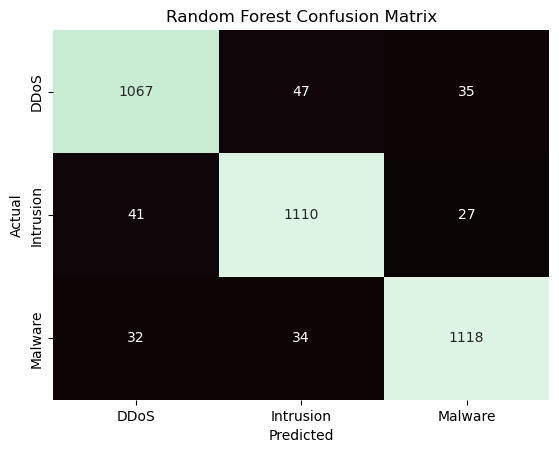

--- Logistic Regression ---
              precision    recall  f1-score   support

        DDoS       0.92      0.88      0.90      1149
   Intrusion       0.88      0.93      0.90      1178
     Malware       0.95      0.94      0.94      1184

    accuracy                           0.92      3511
   macro avg       0.92      0.92      0.92      3511
weighted avg       0.92      0.92      0.92      3511



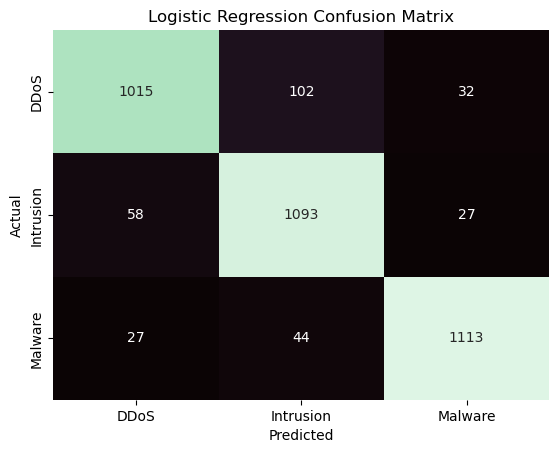

--- SVM (RBF) ---
              precision    recall  f1-score   support

        DDoS       0.94      0.93      0.93      1149
   Intrusion       0.93      0.94      0.93      1178
     Malware       0.95      0.95      0.95      1184

    accuracy                           0.94      3511
   macro avg       0.94      0.94      0.94      3511
weighted avg       0.94      0.94      0.94      3511



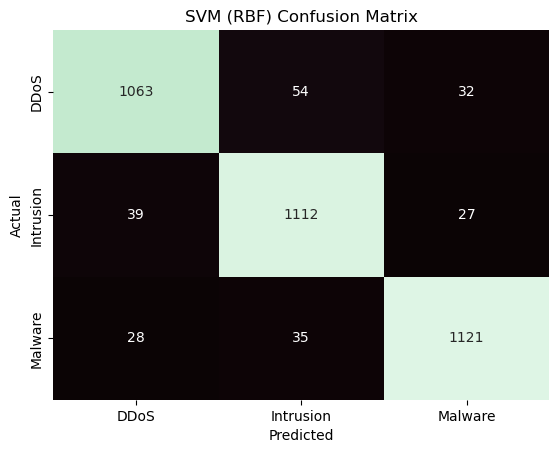

In [9]:
# 7.1 Random Forest
rf = RandomForestClassifier(
    n_estimators=200, class_weight="balanced", random_state=21704
)
rf.fit(X_train, y_train)
evaluate("Random Forest", rf, X_test, y_test)

# 7.2 Logistic Regression
lr = LogisticRegression(
    max_iter=2000, class_weight="balanced", random_state=21704
)
lr.fit(X_train, y_train)
evaluate("Logistic Regression", lr, X_test, y_test)

# 7.3 SVM (RBF)
svm = SVC(
    kernel="rbf", class_weight="balanced", random_state=21704
)
svm.fit(X_train, y_train)
evaluate("SVM (RBF)", svm, X_test, y_test)
